In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import random
import datetime
import pytz

# Text Processing
import re
from collections import defaultdict
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from IPython.display import HTML, display

# Settings and Warnings
import warnings
warnings.filterwarnings("ignore")

# Pandas Display Options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 70)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_colwidth', 1000)

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
data = pd.read_csv('/kaggle/input/reddit_opinion_PSE_ISR.csv')
# data = data.sample(20000, random_state=42)  # Added random_state for reproducibility
data.reset_index(drop=True, inplace=True)

In [3]:
print(f'Data shape: {data.shape}')

Data shape: (1931745, 24)


In [4]:
data.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,user_is_verified,user_account_created_time,user_awardee_karma,user_awarder_karma,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,lp628wz,1,"right, my fairytale is better than yours. IN THE NAME OF MY FAIRYTALE.",worldnews,2024-09-27 11:23:16,1fpmhiv,62burn,0,1,0,True,2015-11-26 00:28:35,0.0,0.0,1.0,3538.0,3539.0,0,NaN,Israeli Bulldozers Flatten Mile After Mile in the West Bank,0.43,0,0,2024-09-26 02:58:04
1,lp626u3,1,"We ~~Aryans~~ Israelis are too smart for the world, that’s why they hate us!\n\n/s",Palestine,2024-09-27 11:22:47,1fq41t1,nagidon,0,1,0,True,2022-03-08 11:13:44,464.0,56.0,71141.0,172521.0,244182.0,449,https://x.com/marinamedvin/status/1838999010805161986?s=46&amp;t=yYjq44e-cxjh4V4RVrYtgQ,"It was recently announced that Israel won’t be allowed to participate as a competing nation in the 2025 International Olympiad in Informatics (IOI) but according to this propagandists, they didn’t get banned because of the genocide in Gaza and war crimes in Lebanon but because they are “too smart”.",0.98,449,0,2024-09-26 19:01:35
2,lp6258l,1,"Is Israel attacking places that have been announced as safezones, killing unarmed civilians, attacking journalists also to protect Israel?",IsraelPalestine,2024-09-27 11:22:24,1fqfzur,CharacterContact6417,0,1,0,True,2024-09-22 19:40:38,0.0,0.0,1.0,0.0,1.0,52,"Too many times, I see people coming to the conclusion that ""Israel is bad because they killed more Palestinians than Palestine killed Israelis""\n\nThis is a complete inversion of responsibilities. As the Israeli government, their job first and foremost is to protect the people of Israel. Likewise, it is the Palestinian government's (Hamas) job to protect the people of Palestine.\n\nThis is what the Israeli government has done to keep Israelis safe:\n\n- Construct bomb shelters in every building\n- Air raid sirens in every city to warn Israelis that they are under attack and to seek shelter\n- Researched and developed one of the most advanced networks of missile defense systems, which includes the Iron Dome, David Sling, Arrow 2 and Arrow 3 \n- Invest a significant portion of their GDP into military to protect its people\n- Seek out alliances both globally (USA/UK/France/Germany) and regionally (Jordan/Egypt/Saudi Arabia/UAE)\n\n\nThis is what the Palestinian government has done to ...",Israel is good because they protect Israelis. Palestine is bad because they harm Palestinians,0.65,52,0,2024-09-27 04:49:29
3,lp624l2,1,"Somehow, it doesn't seem like a very serious issue to you that civilians, including kids, are dying when the very next thing you say is ""lmaoooo."" I don't think it's a laughing matter for anyone, to be honest. It seems like you're looking for reasons to hate the Jews even more at the expense of Lebanese civilians.",CombatFootage,2024-09-27 11:22:14,1fqgvn0,Sheikhaz,0,1,0,True,2018-12-07 15:35:37,597.0,230.0,2786.0,23341.0,26954.0,262,NaN,"Iron Dome intercepting several rockets over Haifa, Israel this morning (September 27, 2024)",0.89,262,0,2024-09-27 05:49:18
4,lp624jb,1,They are legitimate government of Palestine actually. The PA refused to recognize them and overthrew them in Gaza.,IsraelPalestine,2024-09-27 11:22:13,1fqfzur,alysslut-,0,1,0,True,2024-06-13 19:23:53,0.0,0.0,5804.0,12980.0,18784.0,52,"Too many times, I see people coming to the conclusion that ""Israel is bad because they killed more Palestinians than Palestine killed Israelis""\n\nThis is a complete inversion of responsibilities. As the Israeli government, their job first and foremost is to protect the people of Israel. Likewise, it is the Palestinian government's (Hamas) job to protect the people of Palestine.\n\nThis is what the Israeli government has done to keep Israelis safe:\n\n- Construct bomb shelters in every building\n- A

In [5]:
# Drop unnecessary columns
columns_to_drop = [
    'comment_id', 'score', 'author_name', 'controversiality', 'ups', 'downs',
    'user_is_verified', 'user_awardee_karma', 'user_awarder_karma',
    'user_link_karma', 'user_comment_karma', 'post_thumbs_ups', 'post_total_awards_received',
    'post_self_text', 'post_title'
]

data = data.drop(columns=columns_to_drop)

# Verify that the columns have been dropped
print(data.columns)

Index(['self_text', 'subreddit', 'created_time', 'post_id',
       'user_account_created_time', 'user_total_karma', 'post_score',
       'post_upvote_ratio', 'post_created_time'],
      dtype='object')


In [6]:
data['created_time'] = pd.to_datetime(data['created_time'], errors='coerce')
data['post_created_time'] = pd.to_datetime(data['post_created_time'], errors='coerce')
data['user_account_created_time'] = pd.to_datetime(data['user_account_created_time'], errors='coerce')

In [7]:
print(data[['created_time', 'post_created_time', 'user_account_created_time']].isnull().sum())

created_time                     0
post_created_time                0
user_account_created_time    86041
dtype: int64


In [8]:
data.isnull().sum()

self_text                        8
subreddit                        0
created_time                     0
post_id                          0
user_account_created_time    86041
user_total_karma               281
post_score                       0
post_upvote_ratio                0
post_created_time                0
dtype: int64

In [9]:
data.describe(include='all')

,self_text,subreddit,created_time,post_id,user_account_created_time,user_total_karma,post_score,post_upvote_ratio,post_created_time
count,1931737,1931745,1931745,1931745,1845704,1.931464e+06,1.931745e+06,1.931745e+06,1931745
unique,1882620,14,NaN,36714,NaN,NaN,NaN,NaN,NaN
top,Yes,IsraelPalestine,NaN,1b3kg2r,NaN,NaN,NaN,NaN,NaN
freq,636,649610,NaN,621,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2024-03-16 11:26:48.942915328,NaN,2019-09-27 21:43:58.624708096,5.512192e+04,1.595276e+03,7.972359e-01,2024-03-16 01:26:58.780262400
min,NaN,NaN,2023-09-02 12:02:19,NaN,2005-07-28 04:00:00,-9.900000e+01,0.000000e+00,3.000000e-02,2023-09-02 11:52:49
25%,NaN,NaN,2023-12-18 10:41:02,NaN,2017-04-17 17:51:09,2.388000e+03,4.700000e+01,7.100000e-01,2023-12-17 22:09:13
50%,NaN,NaN,2024-03-05 18:42:55,NaN,2020-10-12 11:57:55,1.278900e+04,3.390000e+02,8.600000e-01,2024-03-05 10:22:48
75%,NaN,NaN,2024-05-29 14:09:19,NaN,2022-11-23 21:50:00,4.790725e+04,1.859000e+03,9.400000e-01,2024-05-29 04:31:08
max,NaN,NaN,2024-09-27 11:23:16,NaN,2024-09-27 05:42:32,1.392556e+07,3.779300e+04,1.000000e+00,2024-09-27 11:06:06


In [10]:
import zipfile
import os

zip_file_path = '/usr/share/nltk_data/corpora/wordnet.zip'
destination_directory = '/usr/share/nltk_data/corpora/'

# Check if the specific file exists in the destination directory
file_to_check = 'index.adv'
file_path_to_check = os.path.join(destination_directory, 'wordnet', file_to_check)

if not os.path.exists(file_path_to_check):
    # Unzip the entire archive if the specific file doesn't exist
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_directory)
    print(f"Successfully unzipped {zip_file_path} to {destination_directory}")
else:
    print(f"File {file_to_check} already exists. No need to unzip the archive.")

Successfully unzipped /usr/share/nltk_data/corpora/wordnet.zip to /usr/share/nltk_data/corpora/


In [11]:
# Remove exact duplicates before cleaning
data = data.drop_duplicates(subset=['self_text'])


In [12]:
# Prior to clean_text on self_text 
for i in range(2):
    print(data.self_text[i])

right, my fairytale is better than yours. IN THE NAME OF MY FAIRYTALE.
We ~~Aryans~~ Israelis are too smart for the world, that’s why they hate us!

/s


In [13]:
import re

# Define a dictionary of contractions
contractions_dict = {
    "don't": "do not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "won't": "will not",
    "let's": "let us",
    "wouldn't": "would not",
    "couldn't": "could not",
    "shouldn't": "should not",
    # Add more contractions as needed
}

# Create a regular expression pattern for contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function to expand contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Update your clean_text function
def clean_text(text):
    if not isinstance(text, str):
        return ''
    # Expand contractions
    text = expand_contractions(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove special characters but keep hyphens and numbers
    text = re.sub(r'[^a-zA-Z0-9-\s]', '', text).lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Customize stopwords to keep negations
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the updated clean_text function
data['comments'] = data['self_text'].fillna('').apply(clean_text)

# Display the output
print(data[['self_text', 'comments']].head())

                                                                                                                                                                                                                                                                                                                     self_text  \
0                                                                                                                                                                                                                                                       right, my fairytale is better than yours. IN THE NAME OF MY FAIRYTALE.   
1                                                                                                                                                                                                                                           We ~~Aryans~~ Israelis are too smart for the world, that’s why they hate us!\n\n/s   
2                                 

In [14]:
# Post clean_text on self_text
for i in range(2):
    print(data.self_text[i])

right, my fairytale is better than yours. IN THE NAME OF MY FAIRYTALE.
We ~~Aryans~~ Israelis are too smart for the world, that’s why they hate us!

/s


In [15]:
print("Earliest post_created_time:", data['post_created_time'].min())
print("Latest post_created_time:", data['post_created_time'].max())

Earliest post_created_time: 2023-09-02 11:52:49
Latest post_created_time: 2024-09-27 11:06:06


In [16]:
start_date = pd.to_datetime('2023-10-07')

before = data[(data['post_created_time'] <= start_date) & (data['created_time'] <= start_date)]
print('Len. of data before 2023-10-07:' ,len(before))

# data(posts+comments) starting from '2023-10-07'
after = data[(data['post_created_time'] >= start_date) & (data['created_time'] >= start_date)]
print('Len. of data After 2023-10-07:',len(after))
print('Num. of dropped rows:',len(data)-len(after))

Len. of data before 2023-10-07: 2551
Len. of data After 2023-10-07: 1880019
Num. of dropped rows: 2602


   Period  Number of Posts
0   After          1880019
1  Before             2602


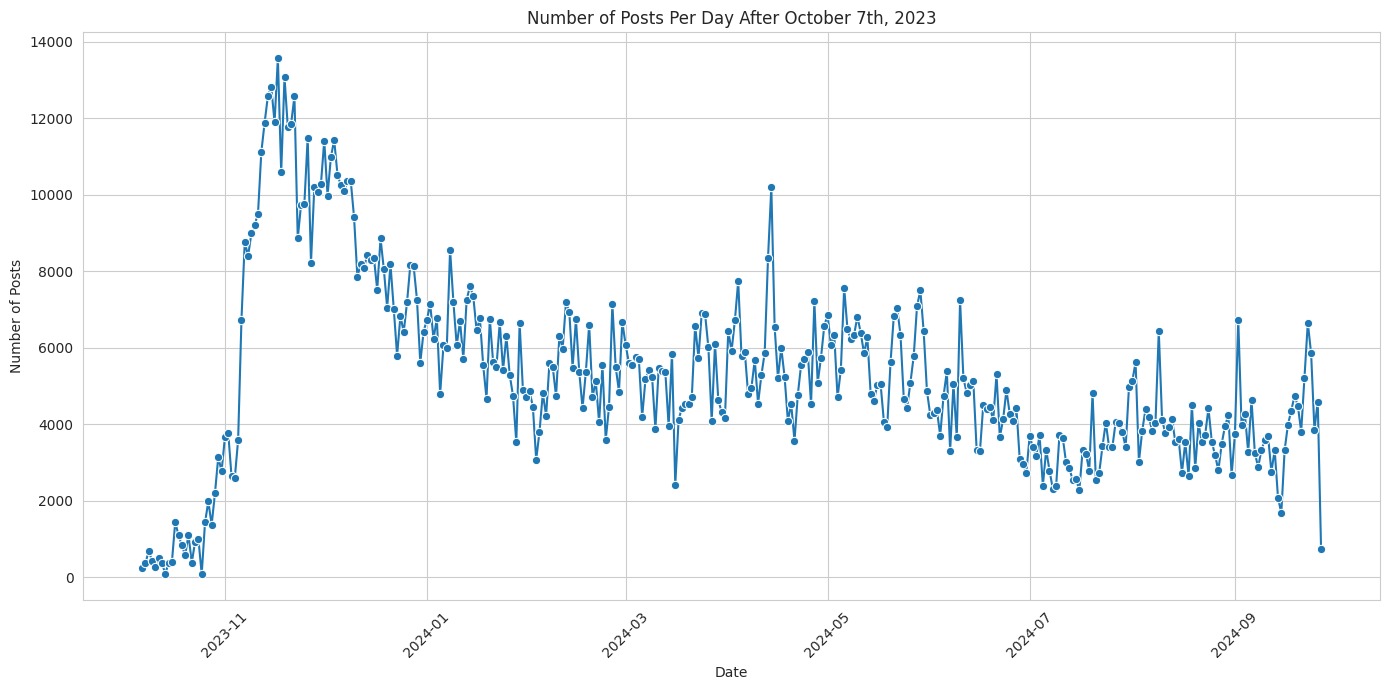

In [17]:
# Drop rows with missing 'post_created_time'
data = data.dropna(subset=['post_created_time'])

# Recreate the 'period' column
data['period'] = data['post_created_time'].apply(lambda x: 'Before' if x < start_date else 'After')

# Verify the counts
posts_count = data['period'].value_counts().reset_index()
posts_count.columns = ['Period', 'Number of Posts']

print(posts_count)

sns.set_style('whitegrid')

# Extract date from 'post_created_time' for posts after October 7th
data_after = data[data['period'] == 'After'].copy()
data_after['date'] = data_after['post_created_time'].dt.date

# Group by date and count the number of posts
posts_per_day = data_after.groupby('date').size().reset_index(name='num_posts')

# Sort the data by date
posts_per_day = posts_per_day.sort_values('date')

# Line plot for number of posts per day after October 7th
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='num_posts', data=posts_per_day, marker='o')

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Number of Posts Per Day After October 7th, 2023')
plt.tight_layout()
plt.show()

In [18]:
# Check for duplicates in cleaned comments
duplicate_clean_comments = data[['comments']].duplicated().sum()
print(f'Duplicate Cleaned Comments: {duplicate_clean_comments}')

'''
However there are many duplicated values, but we can't remove all of them. 
Perhaps it will affect the results, due to many people can share the same post or have the same agreement in the comment.
'''

Duplicate Cleaned Comments: 61241


"\nHowever there are many duplicated values, but we can't remove all of them. \nPerhaps it will affect the results, due to many people can share the same post or have the same agreement in the comment.\n"

# Sentiment Analysis 

In [19]:
import pandas as pd
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Download VADER lexicon (ensure you have internet connectivity)
def initialize_vader():
    try:
        nltk.download('vader_lexicon')
        return SentimentIntensityAnalyzer()
    except Exception as e:
        print(f"Error downloading VADER lexicon: {e}")
        return None  # Proceed without VADER if download fails

vader_analyzer = initialize_vader()

# Set seaborn style for consistency
sns.set_style('whitegrid')

def perform_sentiment_analysis(df, text_column, duplicate_subset, sentiment_score_col, sentiment_category_col):
    """
    Performs sentiment analysis on the specified text column of the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - text_column (str): The column containing text data.
    - duplicate_subset (list): Columns to consider for identifying duplicates.
    - sentiment_score_col (str): Name of the new column for sentiment scores.
    - sentiment_category_col (str): Name of the new column for sentiment categories.
    
    Returns:
    - df_processed (pd.DataFrame): DataFrame with sentiment scores and categories.
    - sentiment_counts (pd.DataFrame): Counts of each sentiment category.
    """
    # Filter out rows with missing text
    df_filtered = df.dropna(subset=[text_column]).copy()
    
    # Remove duplicates based on specified columns
    df_unique = df_filtered.drop_duplicates(subset=duplicate_subset).copy()
    
    # Calculate sentiment polarity using TextBlob
    df_unique[sentiment_score_col] = df_unique[text_column].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )
    
    # Categorize sentiment based on polarity score
    df_unique[sentiment_category_col] = df_unique[sentiment_score_col].apply(
        lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')
    )
    
    # Aggregate sentiment counts
    sentiment_counts = df_unique[sentiment_category_col].value_counts().reset_index()
    sentiment_counts.columns = ['Sentiment', 'Count']
    sentiment_counts = sentiment_counts.sort_values(by='Count', ascending=False)
    
    return df_unique, sentiment_counts

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [20]:
def perform_vader_sentiment_analysis(df, text_column, sentiment_score_col, sentiment_category_col):
    """
    Performs VADER sentiment analysis on the specified text column of the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - text_column (str): The column containing text data.
    - sentiment_score_col (str): Name of the new column for VADER sentiment scores.
    - sentiment_category_col (str): Name of the new column for VADER sentiment categories.
    
    Returns:
    - df (pd.DataFrame): DataFrame with VADER sentiment scores and categories.
    """
    if vader_analyzer:
        df[sentiment_score_col] = df[text_column].apply(
            lambda x: vader_analyzer.polarity_scores(str(x))['compound']
        )
        df[sentiment_category_col] = df[sentiment_score_col].apply(
            lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral')
        )
    else:
        df[sentiment_score_col] = None
        df[sentiment_category_col] = None
        print("VADER analyzer not initialized. Skipping VADER sentiment analysis.")
    
    return df

In [21]:
def plot_sentiment_distribution(sentiment_df, title, xlabel, ylabel):
    """
    Plots a bar chart and a pie chart for sentiment distribution.
    
    Parameters:
    - sentiment_df (pd.DataFrame): DataFrame containing 'Sentiment' and 'Count' columns.
    - title (str): Title for the plots.
    - xlabel (str): Label for the x-axis in the bar chart.
    - ylabel (str): Label for the y-axis in the bar chart.
    """
    # Bar Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Sentiment', y='Count', data=sentiment_df, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Annotate the bars with counts
    for index, row in sentiment_df.iterrows():
        plt.text(index, row['Count'] + max(sentiment_df['Count'])*0.01, f"{row['Count']}", color='black', ha="center")
    
    plt.show()
    
    # Pie Chart
    plt.figure(figsize=(8, 6))
    plt.pie(sentiment_df['Count'], labels=sentiment_df['Sentiment'],
            autopct='%1.1f%%', colors=sns.color_palette('viridis'))
    plt.title(title)
    plt.show()

In [22]:
def sample_data_by_sentiment(df, sentiment_category, sample_size=2, seed=42):
    """
    Samples a specified number of records from the DataFrame based on sentiment category.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - sentiment_category (str): The sentiment category to sample from ('Neutral', 'Positive', 'Negative').
    - sample_size (int): Number of samples to extract.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - sampled_df (pd.DataFrame): Sampled records.
    """
    sampled_df = df[
        (df['comment_sentiment_category'] == sentiment_category) & 
        (df['clean_text'].notnull())
    ].sample(n=sample_size, random_state=seed)
    
    return sampled_df[['post_title', 'clean_text', 'comment_sentiment_score', 'comment_sentiment_category']]

In [23]:
def generate_wordcloud(text, title, stopwords_custom=None):
    """
    Generates and displays a word cloud.
    
    Parameters:
    - text (str): The text data for the word cloud.
    - title (str): Title of the word cloud.
    - stopwords_custom (set): Custom stopwords to exclude.
    """
    wordcloud = WordCloud(width=1600, height=800, background_color='white',
                          stopwords=stopwords_custom, collocations=False).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

In [24]:
# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    # Additional stopwords
    'also', 'say', 'im', 'apostrophe', 're', 've', 'll',  # Your custom stopwords

    # Common Pronouns & Contractions
    'he', 'she', 'it', 'we', 'they', 'us', 'them', 'you', 'isn’t', 'aren’t', 'wasn’t', 'weren’t', 
    'hasn’t', 'haven’t', 'hadn’t', 'didn’t', 'won’t', 'wouldn’t',

    # Articles & Conjunctions
    'a', 'an', 'the', 'and', 'or', 'but', 'so', 'nor', 'yet',

    # Prepositions
    'in', 'on', 'at', 'by', 'for', 'with', 'from', 'about', 'as', 'into', 'through', 
    'over', 'under', 'between',

    # Common Adverbs
    'very', 'really', 'just', 'too', 'quite', 'rather', 'more', 'most', 'less', 'least',

    # Time References
    'now', 'then', 'today', 'tomorrow', 'yesterday', 'soon', 'later', 'always', 'never',

    # Quantifiers
    'all', 'some', 'any', 'many', 'few', 'several', 'each', 'every', 'no', 'none',

    # Interjections
    'oh', 'wow', 'hey', 'yes', 'no', 'hmm', 'ah',

    # Placeholder Words
    'thing', 'something', 'anything', 'everything', 'nothing'
])

In [25]:
# ------------------------------
# Sentiment Analysis on Comments
# ------------------------------

# Perform sentiment analysis on comments
comments_processed, comments_sentiment_counts = perform_sentiment_analysis(
    df=data,
    text_column='comments',
    duplicate_subset=['comments'],
    sentiment_score_col='comment_sentiment_score',
    sentiment_category_col='comment_sentiment_category'
)

# (Optional) Perform VADER sentiment analysis on comments
comments_processed = perform_vader_sentiment_analysis(
    df=comments_processed,
    text_column='comments',
    sentiment_score_col='vader_sentiment_score',
    sentiment_category_col='vader_sentiment_category'
)

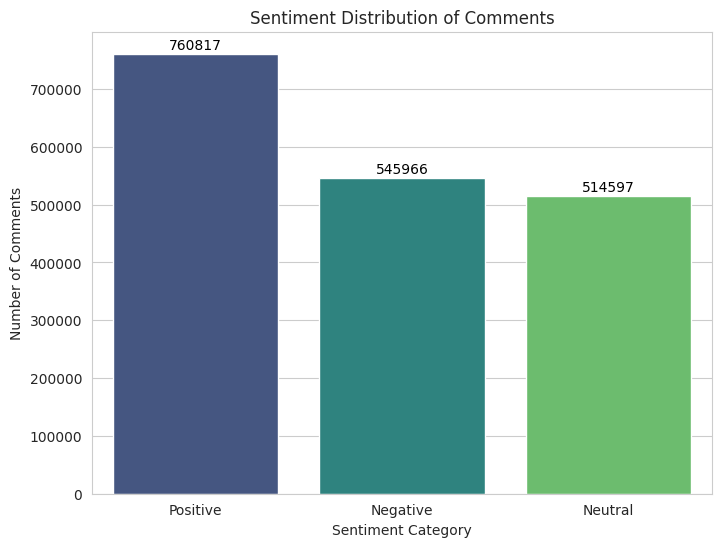

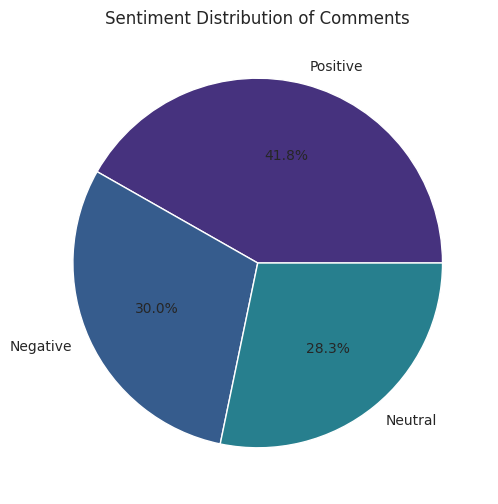

In [26]:
# ------------------------------
# Visualization of Sentiment Distributions
# ------------------------------

# Plot sentiment distributions for comments
plot_sentiment_distribution(
    sentiment_df=comments_sentiment_counts,
    title='Sentiment Distribution of Comments',
    xlabel='Sentiment Category',
    ylabel='Number of Comments'
)

In [27]:
# ------------------------------
# Sampling and Displaying Comments
# ------------------------------

# Function to sample and display comments
def display_sample_comments(df, sentiment_category, sample_size=2, seed=42):
    sampled_comments = df[
        (df['comment_sentiment_category'] == sentiment_category) & 
        (df['comments'].notnull())
    ].sample(n=sample_size, random_state=seed)
    
    print(f"\nSample {sentiment_category} Comments:")
    display(sampled_comments[['comments', 'comment_sentiment_score', 'comment_sentiment_category']])
    
# Sample Neutral, Positive, and Negative Comments
display_sample_comments(comments_processed, 'Neutral')
display_sample_comments(comments_processed, 'Positive')
display_sample_comments(comments_processed, 'Negative')


Sample Neutral Comments:


,comments,comment_sentiment_score,comment_sentiment_category
9435,level self involvement akin brit demanding american avoid celebrating anything 77,0.0,Neutral
1897773,would like harvesting brussels sprout,0.0,Neutral



Sample Positive Comments:


,comments,comment_sentiment_score,comment_sentiment_category
1092171,rofl video,0.8,Positive
1915445,post video palestinian rpalestine think people dont want called anti-semitic frankly whole section city leveled since declaredwar human animal see rworldnews deleting dozensnot exaggerating click palestineisrael post comment favor palestine claiming promoting terrorist,0.1,Positive



Sample Negative Comments:


,comments,comment_sentiment_score,comment_sentiment_category
1073565,seem majority killing history careless engagement lead civilian death ill curious see u investigation yield,-0.366667,Negative
126329,genociding jew must missed statement thought wanted statehood end occupation oppression missed blatant racism hate towards jew please providence evidence great desire wipe jew,-0.166667,Negative


In [28]:
# ------------------------------
# Word Cloud Generation for Sentiment Categories
# ------------------------------

def create_sentiment_wordclouds(df, text_column, sentiment_category_col, title_prefix):
    """
    Generates and displays word clouds for each sentiment category.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - text_column (str): The column containing text data.
    - sentiment_category_col (str): The column containing sentiment categories.
    - title_prefix (str): Prefix for the title of the word clouds.
    """
    sentiments = ['Neutral', 'Positive', 'Negative']
    for sentiment in sentiments:
        subset = df[df[sentiment_category_col] == sentiment][text_column]
        combined_text = ' '.join(subset.dropna())
        if combined_text:  # Check if there is text to generate word cloud
            generate_wordcloud(
                text=combined_text,
                title=f'Word Cloud of {sentiment} {title_prefix}',
                stopwords_custom=custom_stopwords
            )
        else:
            print(f"No data available for {sentiment} in {title_prefix}.")

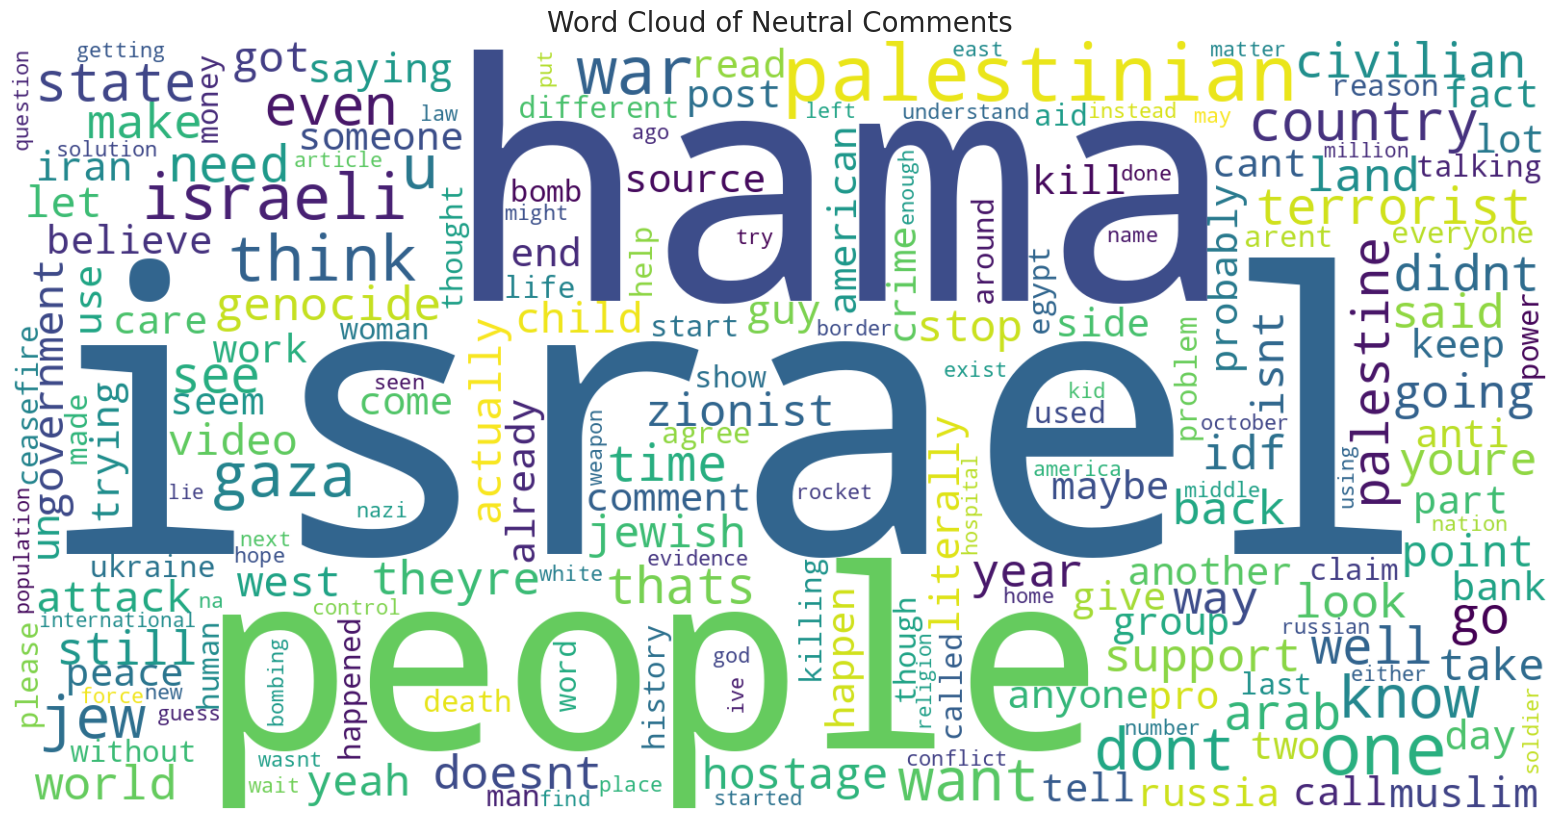

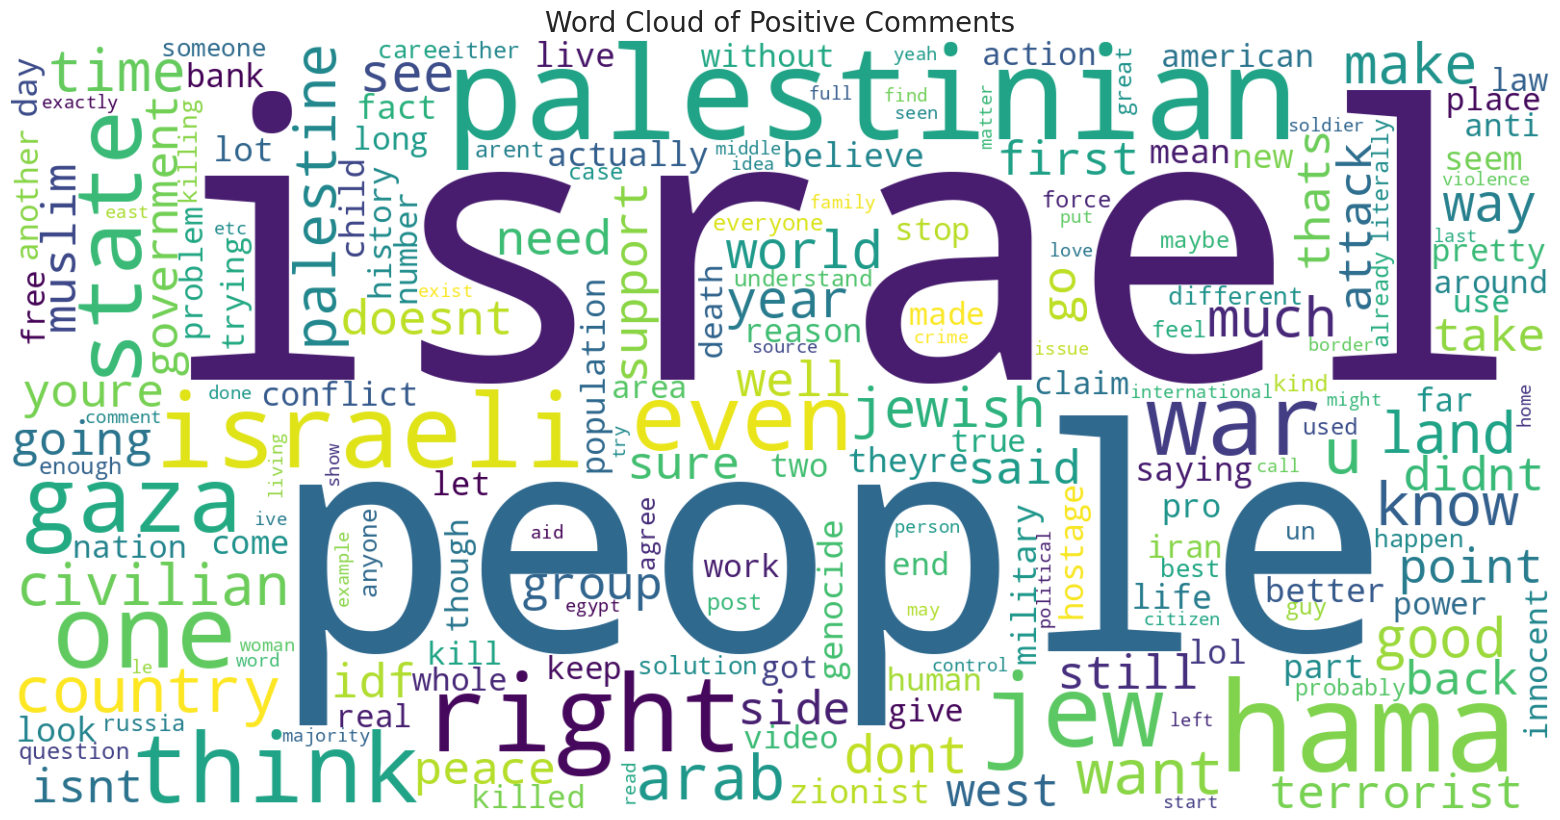

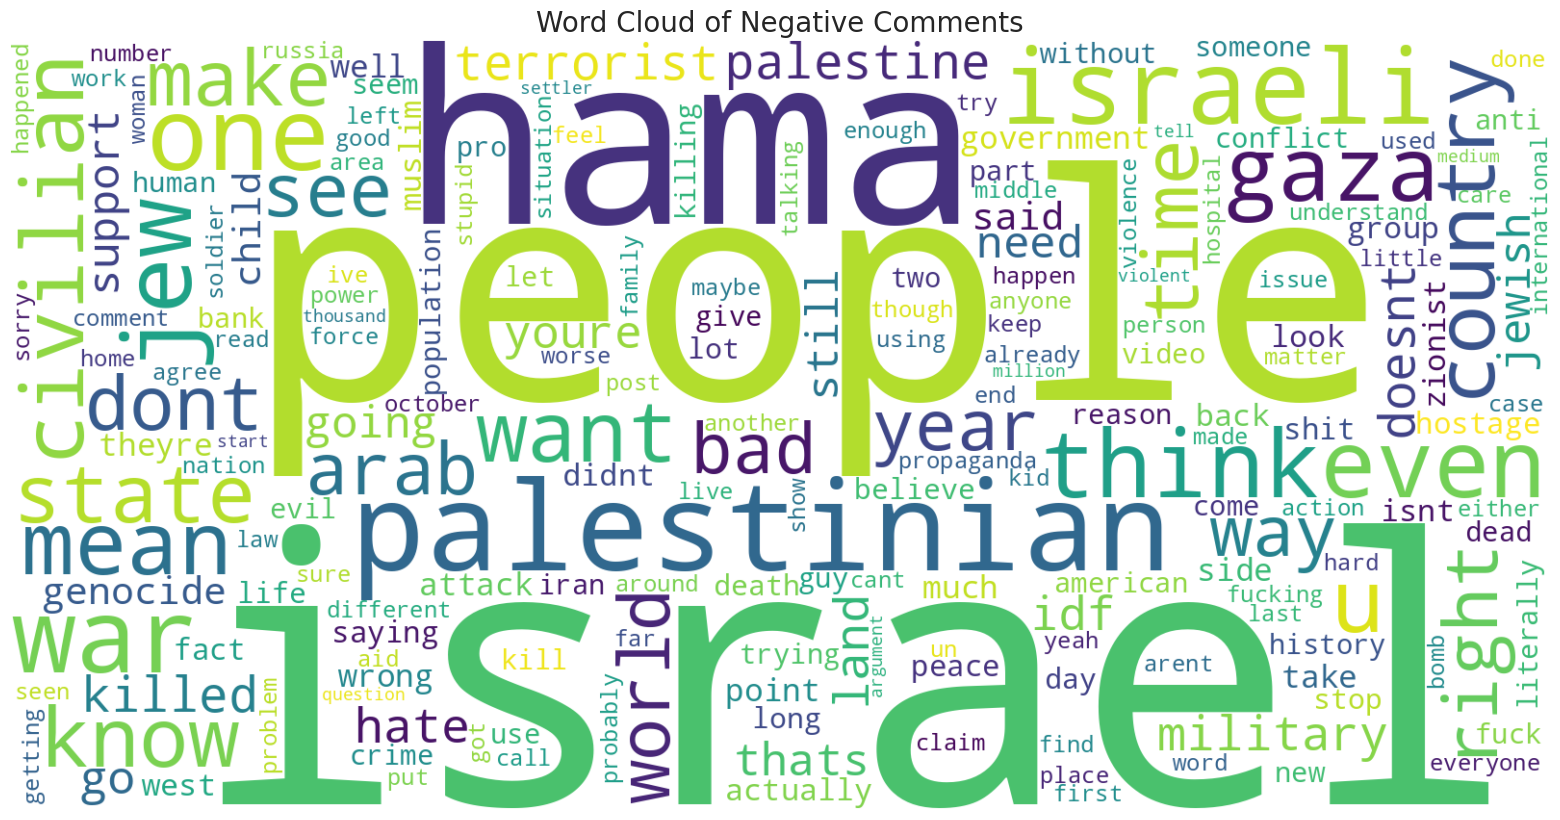

In [29]:
# Generate Word Clouds for Comments
create_sentiment_wordclouds(
    df=comments_processed,
    text_column='comments',
    sentiment_category_col='comment_sentiment_category',
    title_prefix='Comments'
)

In [30]:
def compare_sentiment_methods(df, text_column, textblob_category_col, vader_category_col, title):
    """
    Compares TextBlob and VADER sentiment categorizations.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - text_column (str): The column containing text data.
    - textblob_category_col (str): Column for TextBlob sentiment categories.
    - vader_category_col (str): Column for VADER sentiment categories.
    - title (str): Title for the comparison plot.
    """
    # Merge the sentiment categories
    comparison = df[[textblob_category_col, vader_category_col]].dropna()
    
    # Crosstab to see alignment
    crosstab = pd.crosstab(comparison[textblob_category_col], comparison[vader_category_col], normalize='index') * 100
    print(f"\nSentiment Comparison between TextBlob and VADER for {title}:")
    print(crosstab)
    
    # Heatmap of the crosstab
    plt.figure(figsize=(8,6))
    sns.heatmap(crosstab, annot=True, fmt=".1f", cmap='YlGnBu')
    plt.title(f'Sentiment Comparison: TextBlob vs. VADER for {title}')
    plt.xlabel('VADER Sentiment Category')
    plt.ylabel('TextBlob Sentiment Category')
    plt.show()


Sentiment Comparison between TextBlob and VADER for Comments:
vader_sentiment_category     Negative    Neutral   Positive
comment_sentiment_category                                 
Negative                    72.299923   6.564145  21.135932
Neutral                     34.589980  40.526470  24.883550
Positive                    40.763022   7.181622  52.055356


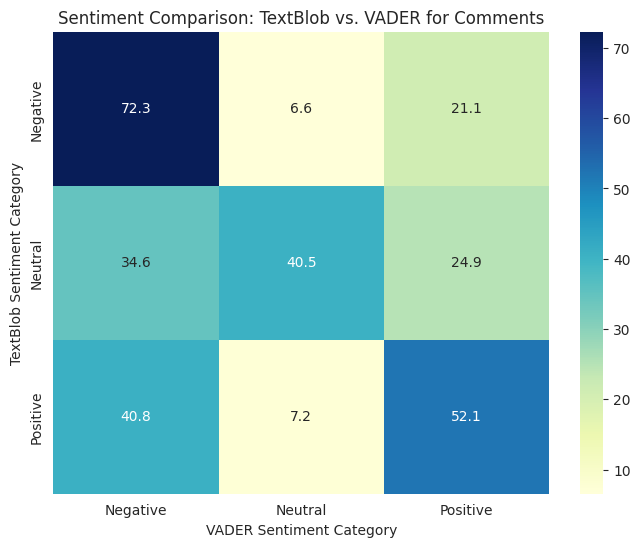

In [31]:
# Compare sentiment methods for Comments
compare_sentiment_methods(
    df=comments_processed,
    text_column='comments',
    textblob_category_col='comment_sentiment_category',
    vader_category_col='vader_sentiment_category',
    title='Comments'
)

In [32]:
def plot_sentiment_over_time(df, sentiment_score_col, date_col, title):
    """
    Plots the average sentiment score over time.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - sentiment_score_col (str): The column containing sentiment scores.
    - date_col (str): The column containing date information.
    - title (str): Title of the plot.
    """
    # Group by date and calculate average sentiment score
    sentiment_over_time = df.groupby(date_col)[sentiment_score_col].mean().reset_index()
    
    # Line Plot for Average Sentiment Over Time
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=date_col, y=sentiment_score_col, data=sentiment_over_time, marker='o', color='blue')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.tight_layout()
    plt.show()
    
    return sentiment_over_time

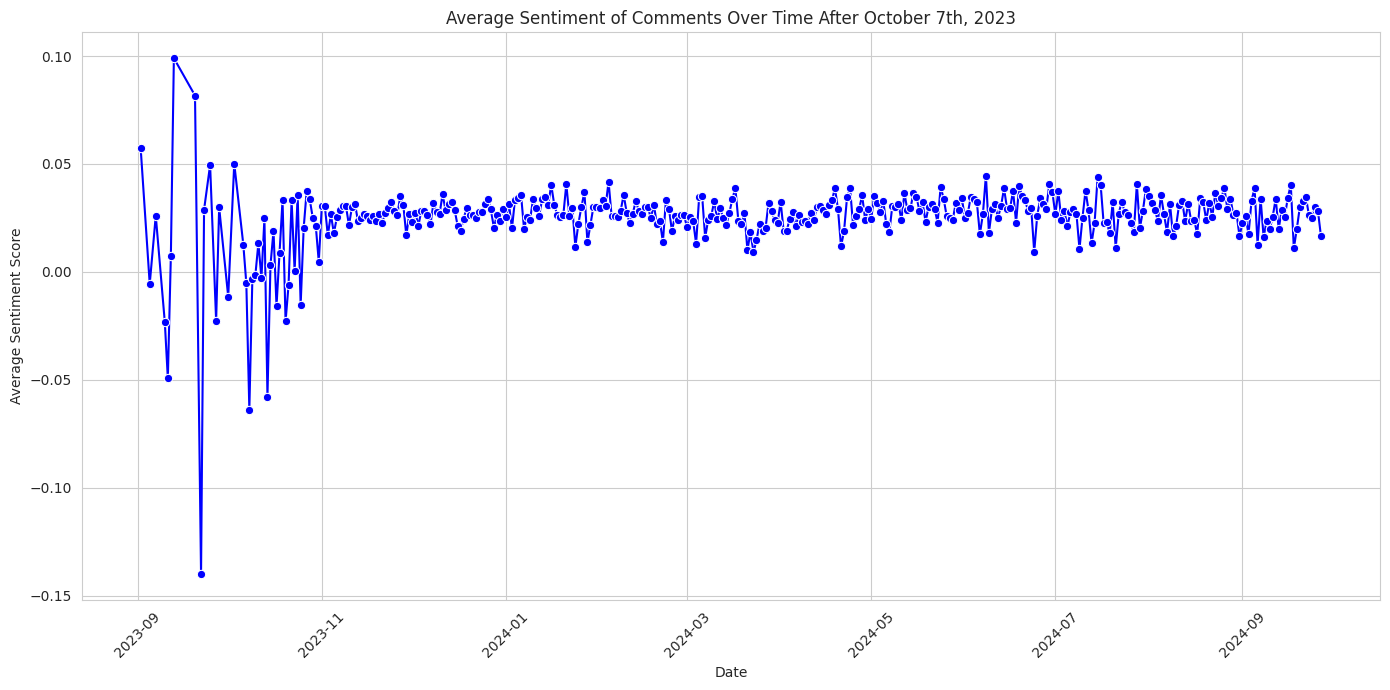

In [33]:
# Convert 'post_created_time' to datetime for comments (assuming 'post_created_time' is relevant)
comments_processed['comment_created_time'] = pd.to_datetime(comments_processed['post_created_time'])

# Extract date from 'comment_created_time'
comments_processed['comment_date'] = comments_processed['comment_created_time'].dt.date

# Plot sentiment over time for comments
sentiment_over_time_comments = plot_sentiment_over_time(
    df=comments_processed,
    sentiment_score_col='comment_sentiment_score',
    date_col='comment_date',
    title='Average Sentiment of Comments Over Time After October 7th, 2023'
)

In [34]:
def plot_cumulative_sentiment(sentiment_over_time, sentiment_score_col, date_col, title):
    """
    Plots the cumulative sentiment score over time.
    
    Parameters:
    - sentiment_over_time (pd.DataFrame): DataFrame with sentiment over time.
    - sentiment_score_col (str): The column containing sentiment scores.
    - date_col (str): The column containing date information.
    - title (str): Title of the plot.
    """
    # Calculate cumulative sentiment
    sentiment_over_time['cumulative_sentiment'] = sentiment_over_time[sentiment_score_col].cumsum()
    
    # Line Plot for Cumulative Sentiment
    plt.figure(figsize=(14,7))
    sns.lineplot(x=date_col, y='cumulative_sentiment', data=sentiment_over_time, marker='o', color='green')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sentiment Score')
    plt.tight_layout()
    plt.show()

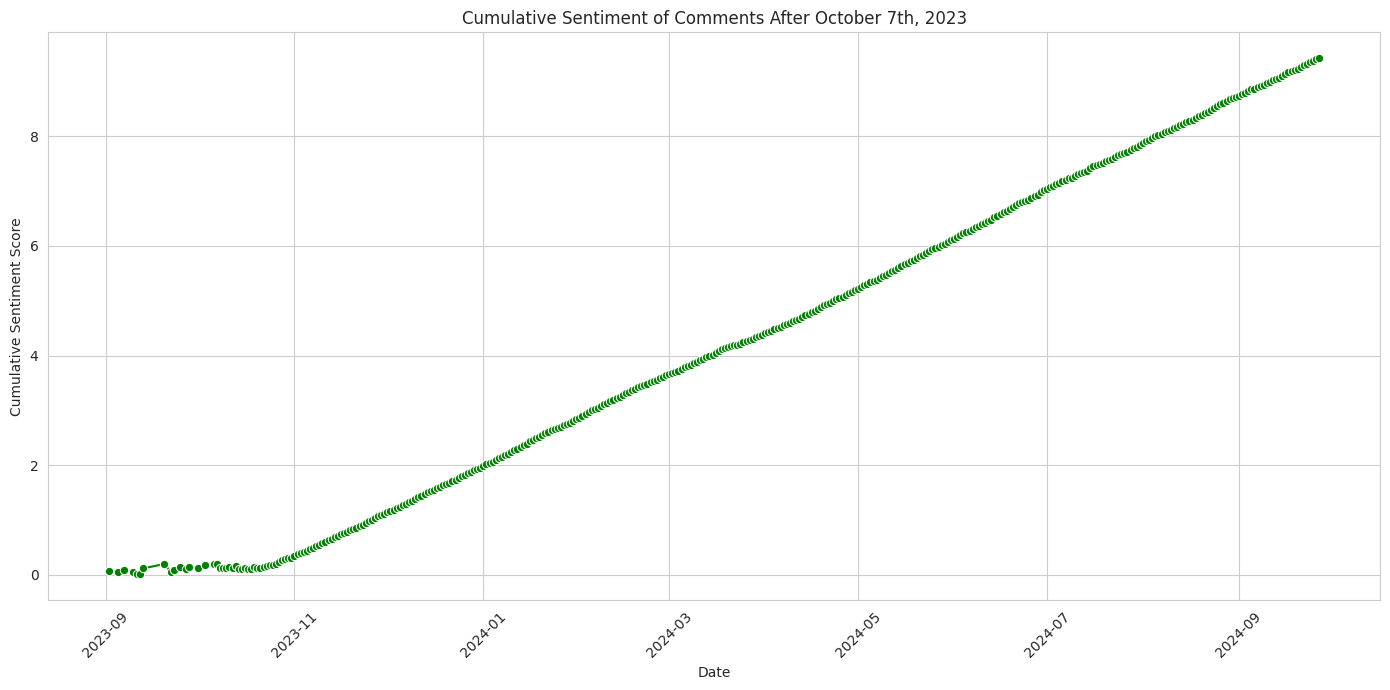

In [35]:
# Plot cumulative sentiment for comments
plot_cumulative_sentiment(
    sentiment_over_time=sentiment_over_time_comments,
    sentiment_score_col='comment_sentiment_score',
    date_col='comment_date',
    title='Cumulative Sentiment of Comments After October 7th, 2023'
)

In [36]:
# ------------------------------
# Summary Statistics of Sentiment Scores
# ------------------------------

# Summary statistics for TextBlob sentiment scores in comments
print("\nSummary Statistics for TextBlob Sentiment Scores (Comments):")
print(comments_processed['comment_sentiment_score'].describe())

# Summary statistics for VADER sentiment scores in comments (if available)
if vader_analyzer:
    print("\nSummary Statistics for VADER Sentiment Scores (Comments):")
    print(comments_processed['vader_sentiment_score'].describe())


Summary Statistics for TextBlob Sentiment Scores (Comments):
count    1.821380e+06
mean     2.722239e-02
std      2.510023e-01
min     -1.000000e+00
25%     -5.000000e-02
50%      0.000000e+00
75%      1.333333e-01
max      1.000000e+00
Name: comment_sentiment_score, dtype: float64

Summary Statistics for VADER Sentiment Scores (Comments):
count    1.821380e+06
mean    -1.134994e-01
std      5.401233e-01
min     -9.999000e-01
25%     -5.873000e-01
50%      0.000000e+00
75%      3.182000e-01
max      9.999000e-01
Name: vader_sentiment_score, dtype: float64


In [37]:
# ------------------------------
# Box Plot of Sentiment Scores by Category
# ------------------------------

def plot_boxplot(df, sentiment_category_col, sentiment_score_col, title):
    """
    Plots a box plot of sentiment scores by sentiment category.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - sentiment_category_col (str): The column containing sentiment categories.
    - sentiment_score_col (str): The column containing sentiment scores.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(8,6))
    sns.boxplot(x=sentiment_category_col, y=sentiment_score_col, data=df, palette='Set3')
    plt.title(f'Box Plot of TextBlob Sentiment Scores by Category for{title}')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Sentiment Score')
    plt.show()
    
    # Optional: Box plot for VADER sentiment scores
    if 'vader_sentiment_score' in df.columns and 'vader_sentiment_category' in df.columns:
        plt.figure(figsize=(8,6))
        sns.boxplot(x='vader_sentiment_category', y='vader_sentiment_score', data=df, palette='Set2')
        plt.title(f'Box Plot of VADER Sentiment Scores by Category for {title}')
        plt.xlabel('VADER Sentiment Category')
        plt.ylabel('VADER Sentiment Score')
        plt.show()

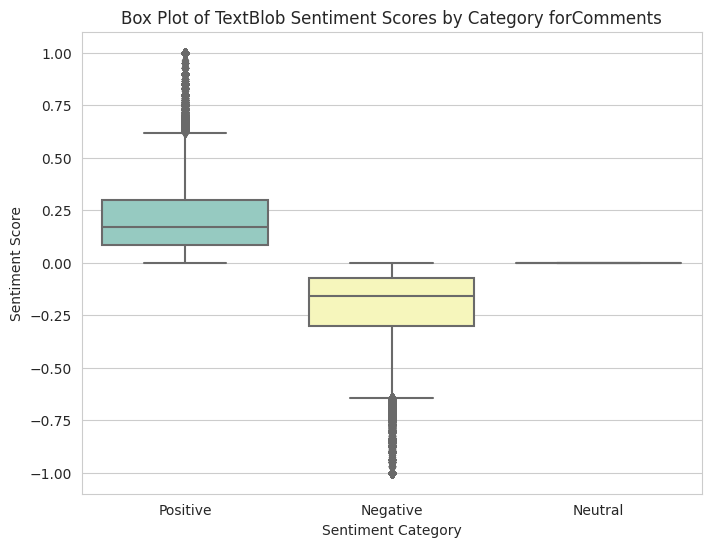

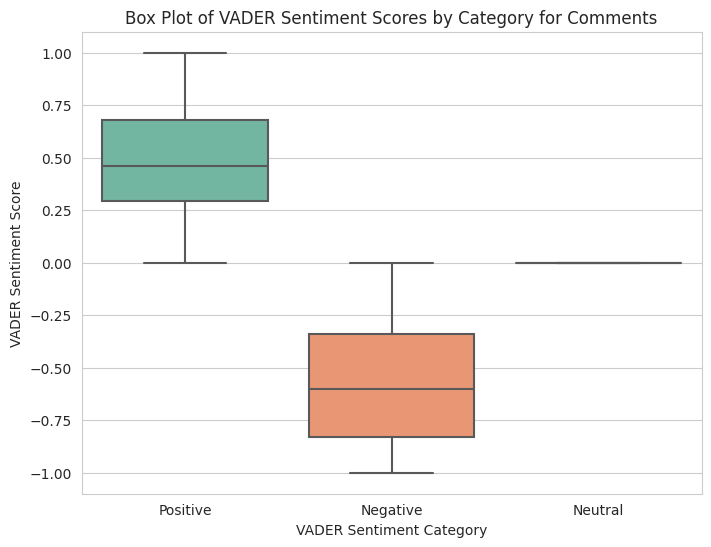

In [38]:
# Plot box plot for comments
plot_boxplot(
    df=comments_processed,
    sentiment_category_col='comment_sentiment_category',
    sentiment_score_col='comment_sentiment_score',
    title='Comments'
)

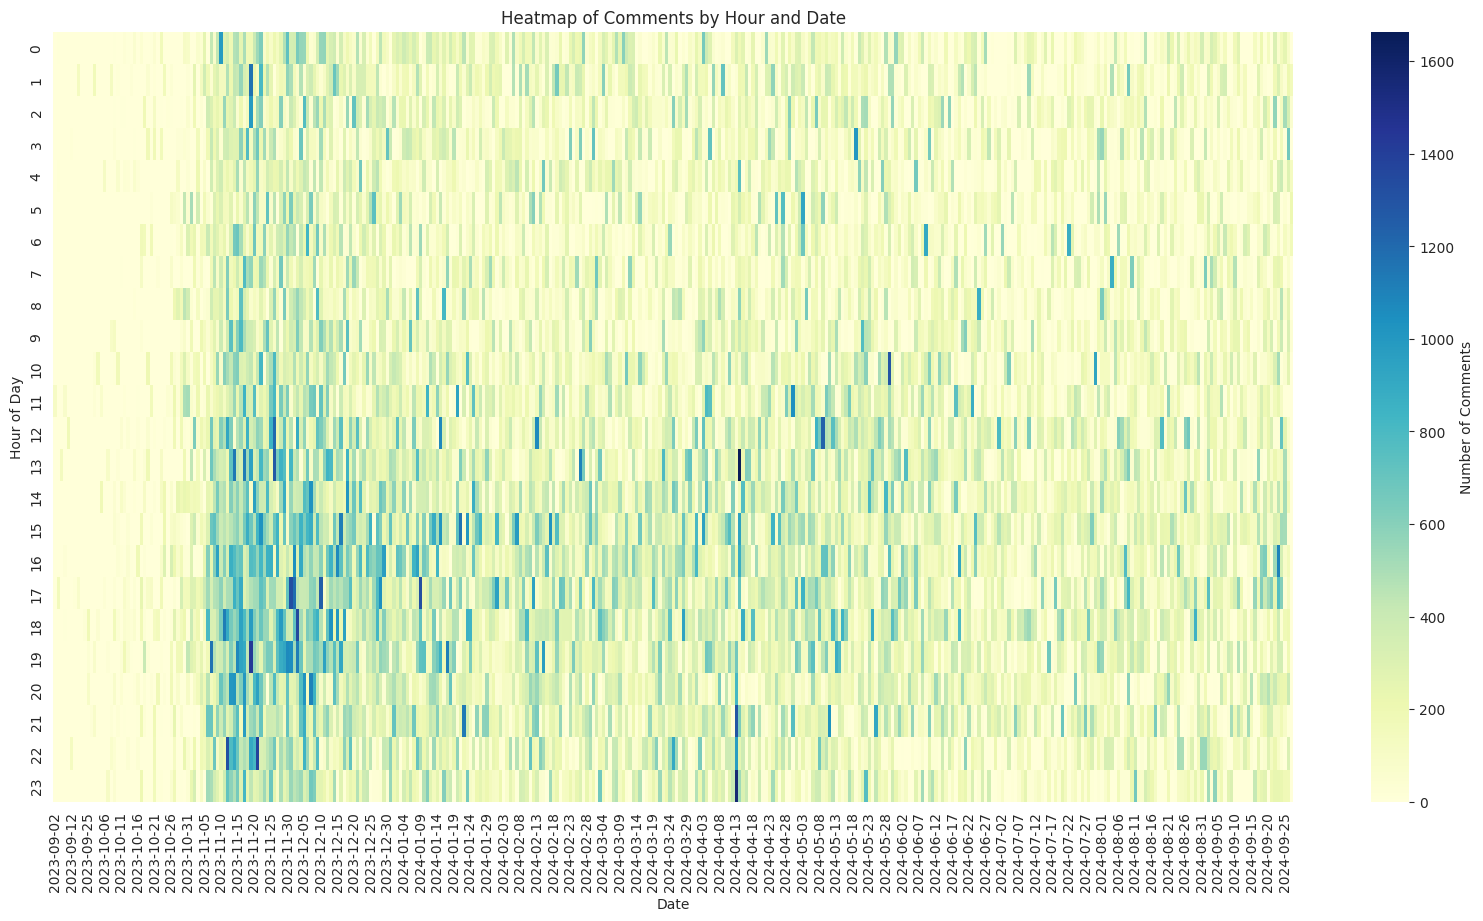

In [39]:
# ------------------------------
# Heatmap of Comments by Day and Hour
# ------------------------------

def plot_heatmap(df, datetime_col, title):
    """
    Plots a heatmap of comment counts by hour and date.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - datetime_col (str): The column containing datetime information.
    - title (str): Title of the heatmap.
    """
    # Extract hour and date from datetime column
    df['hour'] = df[datetime_col].dt.hour
    df['date'] = df[datetime_col].dt.date
    
    # Create a pivot table of comment counts
    heatmap_data = df.pivot_table(index='hour', columns='date', values='comments', aggfunc='count').fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Number of Comments'})
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Hour of Day')
    plt.show()

# Plot heatmap for comments
plot_heatmap(
    df=comments_processed,
    datetime_col='comment_created_time',  # Ensure this column exists and is properly formatted
    title='Heatmap of Comments by Hour and Date'
)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling(df, text_column, num_topics=5, num_words=10):
    """
    Performs topic modeling using LDA and prints top words for each topic.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - text_column (str): The column containing text data.
    - num_topics (int): Number of topics to extract.
    - num_words (int): Number of top words to display per topic.
    """
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df[text_column])
    
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)
    
    for index, topic in enumerate(lda.components_):
        print(f"Top {num_words} words for topic #{index + 1}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]])
        print("\n")

# Perform topic modeling on comments
print("Performing topic modeling for cleaned comments")
perform_topic_modeling(comments_processed, 'comments', num_topics=5, num_words=10)

Performing topic modeling for cleaned comments
Top 10 words for topic #1:
['palestine', 'state', 'muslim', 'palestinian', 'israel', 'land', 'jewish', 'people', 'arab', 'jew']


Top 10 words for topic #2:
['attack', 'israeli', 'terrorist', 'killed', 'war', 'gaza', 'idf', 'israel', 'civilian', 'hamas']


Top 10 words for topic #3:
['dont', 'video', 'youre', 'guy', 'time', 'think', 'know', 'im', 'people', 'like']


Top 10 words for topic #4:
['russia', 'think', 'support', 'war', 'iran', 'government', 'like', 'people', 'country', 'israel']


Top 10 words for topic #5:
['state', 'genocide', 'want', 'war', 'gaza', 'israeli', 'people', 'hamas', 'palestinian', 'israel']


